In [1]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
from pprint import pprint


es = Elasticsearch()

if not(es.indices.exists(index="tarea5")):
    res = es.indices.create(index="tarea5")  
    pprint(res)

In [2]:
#LISTAR LOS ARCHIVOS DEL DATASET
import json
import os
files = os.listdir("split_dataset_1")
pprint(len(files))

354585


In [3]:
from elasticsearch import helpers

#CARGAR LOS DATOS EN ELASTICSEARCH
tweets=[]

for filename in files:
    with open('split_dataset_1/'+filename) as f:
        try:
            #pprint(filename+':')
            tweet = json.load(f)
            timestamp=int(tweet["timestamp_ms"])
            #pprint(tweet)
            simple_tweet = {
                "timestamp":timestamp, \
                "date":tweet["created_at"], \
                "text": tweet['text'], \
                "username": tweet['user']['name'], \
                "location": tweet['user']['location']}
        except KeyError:
            error="error"
            
    tweets.append(simple_tweet)#remove comment
    
    #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
    if (len(tweets)>=1000):
        i=0
        docs_as_string="["
        while i<1000:
            if i!=0:
                docs_as_string = docs_as_string + ','
            docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
            i=i+1
        docs_as_string=docs_as_string+"]"
        res = helpers.bulk(es, json.loads(docs_as_string),index="tarea5", doc_type="_doc")
        tweets=[]


1) ¿Cuántos tweets tienen la palabra "liverpool"? ¿Cómo se distribuye los tweets en el tiempo (ver en un histograma)

In [13]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
from elasticsearch import Elasticsearch
from pprint import pprint
es = Elasticsearch()


In [38]:
res = es.search(index="tarea5", body={"query": {"match":{"text":"liverpool"}}})
print("cantidad: %d" % res['hits']['total'])



cantidad: 44129


In [24]:
res = es.search(index="tarea5", body={"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})

In [31]:
import pandas as pd

a= pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
a= a.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})



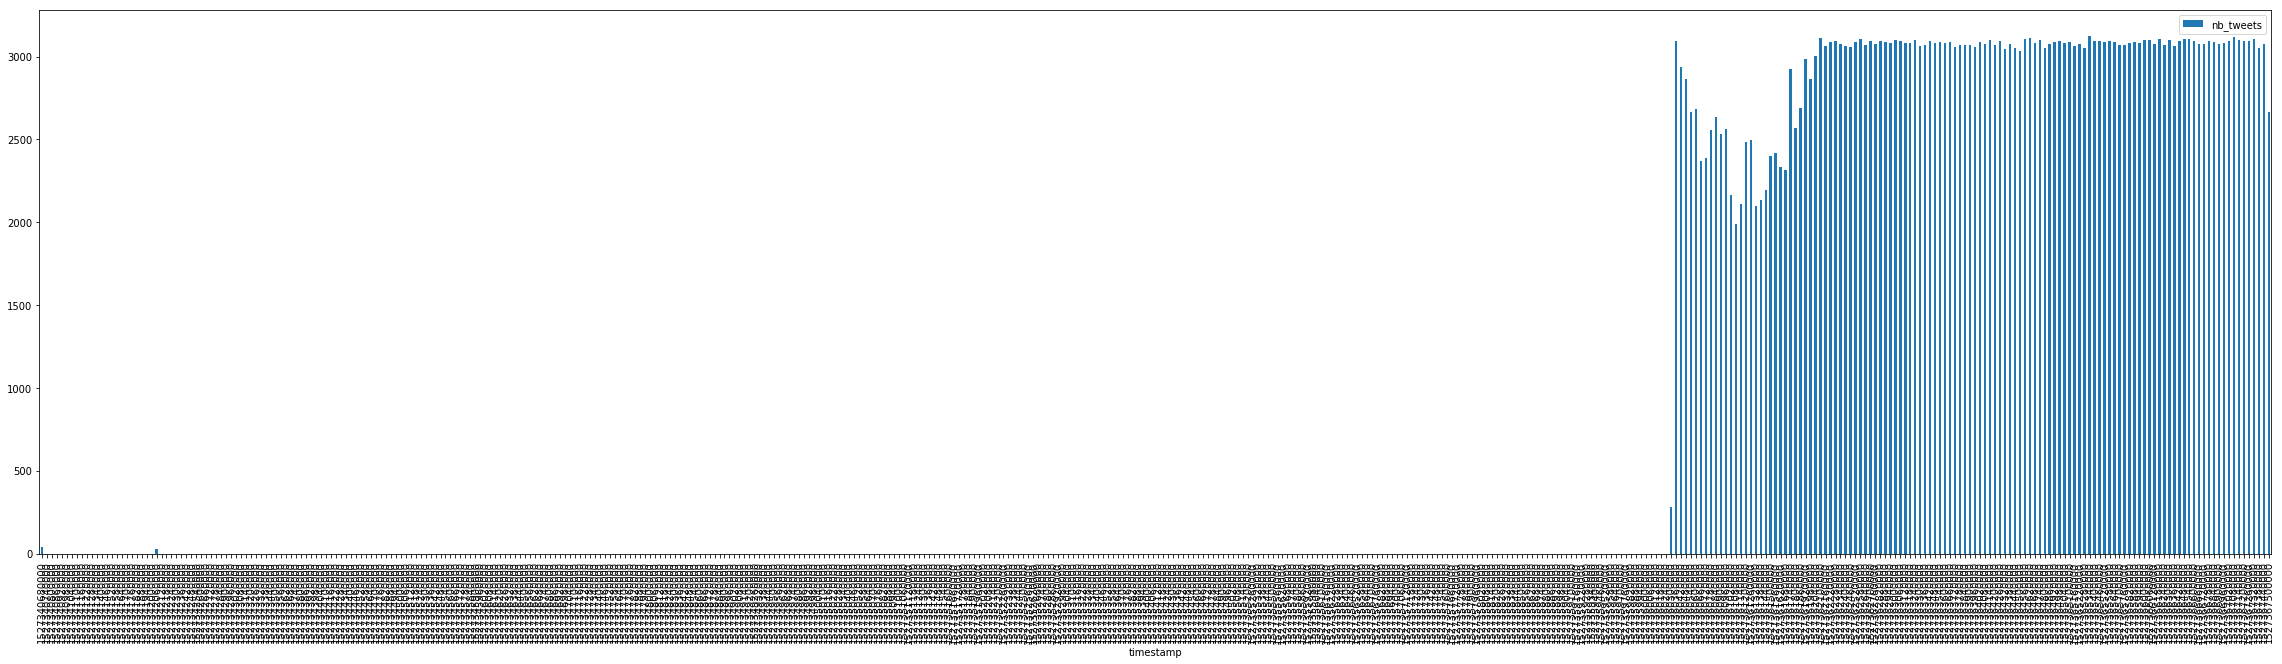

In [30]:
import matplotlib.pyplot as plt

a.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

2)¿De dónde vienen los tweets? (utilizar el campo 'location')

In [35]:
res = es.search(index="tarea5", body={"query": {"match_all": {}}})
for hit in res['hits']['hits']:
    print(hit["_source"]["location"])

None
Tema 🇬🇭
Barcelona, Spanien
Lusaka, Zambia
Né le 28 mars 1997 à Saragosse
London
(Hackney)Endz, UK
Paraguay
Venezuela
None


3)¿Cuántos tweets tienen las palabras "liverpool" y "goal"? (ver en un histograma)

In [74]:
res = es.search(index="tarea5", body={"query" : {"bool" : {"must": [{"match": {"text": "liverpool"}},
{"match": {"text": "goal"}}]} }})
print("cantidad: %d" % res['hits']['total'])


cantidad: 1636


4) Graficar un Pie Chart comparando el número de tweets con: a) la palabra 'liverpool', b) la palabra 'madrid', c) la palabra 'madrid' y 'liverpool' d) ninguna de las palabras

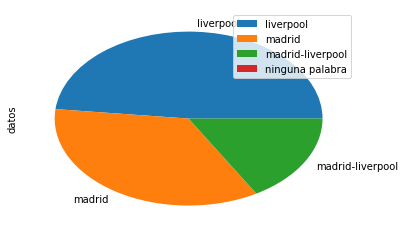

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
res = es.search(index="tarea5", body={"query": {"match":{"text":"liverpool"}}})
a=res['hits']['total']
res = es.search(index="tarea5", body={"query": {"match":{"text":"madrid"}}})
b=res['hits']['total']
res = es.search(index="tarea5", body={"query" : {"bool" : {"must": [{"match": {"text": "madrid"}},
{"match": {"text": "liverpool"}}]} }})
c=res['hits']['total']
d=0
series = pd.Series([a,b,c,d], index=['liverpool', 'madrid','madrid-liverpool','ninguna palabra'], name='datos')
series.plot(kind='pie', legend=True)
plt.show()

5) ¿Cuáles son los emoticons más frecuentes? A partir de las visualizaciones disponibles en las librerias MatplotLib y/o Seaborn (seaborn.pydata.org), proponer una visualización para observar las emociones expresadas durante el partido